In [17]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
from paddleocr import PaddleOCR

# --- 1. Setup ---
# Initialize PaddleOCR (downloads model automatically on first run)
# lang='en' covers english alphanumeric characters (standard for plates)
# Użyj modelu "server" zamiast "mobile" - wolniejszy ale dokładniejszy
# det_model_name - model detekcji tekstu
# rec_model_name - model rozpoznawania tekstu (to jest kluczowe!)
ocr = PaddleOCR(
    lang="en",
    ocr_version="PP-OCRv4",
    text_detection_model_name="PP-OCRv4_server_det",
    text_recognition_model_name="PP-OCRv4_server_rec",
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=True,  # odpowiednik "angle/cls" w nowym pipeline
)

root = Path.cwd()
image_path = root / "z29927594AMP.jpg"
model_path = root / "license-plate-finetune-v1n.onnx"  # Use ONNX model

assert image_path.exists(), f"Missing image: {image_path}"
assert model_path.exists(), f"Missing model: {model_path}"

# Load ONNX model with onnxruntime
session = ort.InferenceSession(str(model_path), providers=['CPUExecutionProvider'])
input_name = session.get_inputs()[0].name
input_shape = session.get_inputs()[0].shape  # e.g., [1, 3, 640, 640] or dynamic ['batch', 3, 'height', 'width']

print("image_path:", image_path)
print("model_path:", model_path)
print(f"Model input shape: {input_shape} (dynamic dims will use 640)")

/tmp/ipykernel_106729/1864221780.py:15: UserWarning: `lang` and `ocr_version` will be ignored when model names or model directories are not `None`.
  ocr = PaddleOCR(
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/petitoff/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv4_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/petitoff/.paddlex/official_models/PP-OCRv4_server_det`.
Creating model: ('PP-OCRv4_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/petitoff/.paddlex/official_models/PP-OCRv4_server_rec`.


image_path: /home/petitoff/repos/license_plate_ocr/z29927594AMP.jpg
model_path: /home/petitoff/repos/license_plate_ocr/license-plate-finetune-v1n.onnx
Model input shape: ['batch', 3, 'height', 'width'] (dynamic dims will use 640)


In [18]:
# --- ONNX YOLO Inference Helpers (no ultralytics needed) ---

def preprocess_image_for_yolo(image_bgr: np.ndarray, target_size: tuple[int, int] = (640, 640)) -> tuple[np.ndarray, tuple[float, float], tuple[int, int]]:
    """
    Preprocess image for YOLOv8 ONNX model.
    Returns: (preprocessed_tensor, scale_factors, padding)
    """
    h, w = image_bgr.shape[:2]
    target_h, target_w = target_size
    
    # Calculate scale to fit while maintaining aspect ratio
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize image
    resized = cv2.resize(image_bgr, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    # Create padded image (letterbox)
    padded = np.full((target_h, target_w, 3), 114, dtype=np.uint8)
    pad_w = (target_w - new_w) // 2
    pad_h = (target_h - new_h) // 2
    padded[pad_h:pad_h + new_h, pad_w:pad_w + new_w] = resized
    
    # Convert BGR -> RGB, HWC -> CHW, normalize to [0, 1]
    img_rgb = cv2.cvtColor(padded, cv2.COLOR_BGR2RGB)
    img_chw = img_rgb.transpose(2, 0, 1).astype(np.float32) / 255.0
    img_batch = np.expand_dims(img_chw, axis=0)  # Add batch dimension
    
    return img_batch, (scale, scale), (pad_w, pad_h)


def postprocess_yolo_output(
    output: np.ndarray, 
    original_shape: tuple[int, int],
    scale: tuple[float, float],
    padding: tuple[int, int],
    conf_threshold: float = 0.25,
    iou_threshold: float = 0.45
) -> list[dict]:
    """
    Postprocess YOLOv8 ONNX output to get bounding boxes.
    
    Args:
        output: Model output of shape [1, num_classes+4, num_predictions] (YOLOv8 format)
        original_shape: Original image (h, w)
        scale: Scale factors used during preprocessing
        padding: Padding (pad_w, pad_h) used during preprocessing
        conf_threshold: Confidence threshold
        iou_threshold: IoU threshold for NMS
    
    Returns:
        List of detections with 'bbox_xyxy' and 'conf'
    """
    # YOLOv8 output is [1, 4+num_classes, num_predictions]
    # Transpose to [num_predictions, 4+num_classes]
    predictions = output[0].T  # Shape: [num_predictions, 4+num_classes]
    
    # Extract boxes (cx, cy, w, h) and class scores
    boxes_cxcywh = predictions[:, :4]
    class_scores = predictions[:, 4:]
    
    # Get best class and confidence for each prediction
    confidences = np.max(class_scores, axis=1)
    class_ids = np.argmax(class_scores, axis=1)
    
    # Filter by confidence
    mask = confidences > conf_threshold
    boxes_cxcywh = boxes_cxcywh[mask]
    confidences = confidences[mask]
    class_ids = class_ids[mask]
    
    if len(boxes_cxcywh) == 0:
        return []
    
    # Convert cx, cy, w, h -> x1, y1, x2, y2
    boxes_xyxy = np.zeros_like(boxes_cxcywh)
    boxes_xyxy[:, 0] = boxes_cxcywh[:, 0] - boxes_cxcywh[:, 2] / 2  # x1
    boxes_xyxy[:, 1] = boxes_cxcywh[:, 1] - boxes_cxcywh[:, 3] / 2  # y1
    boxes_xyxy[:, 2] = boxes_cxcywh[:, 0] + boxes_cxcywh[:, 2] / 2  # x2
    boxes_xyxy[:, 3] = boxes_cxcywh[:, 1] + boxes_cxcywh[:, 3] / 2  # y2
    
    # Remove padding and rescale to original image coordinates
    pad_w, pad_h = padding
    scale_x, scale_y = scale
    
    boxes_xyxy[:, 0] = (boxes_xyxy[:, 0] - pad_w) / scale_x
    boxes_xyxy[:, 1] = (boxes_xyxy[:, 1] - pad_h) / scale_y
    boxes_xyxy[:, 2] = (boxes_xyxy[:, 2] - pad_w) / scale_x
    boxes_xyxy[:, 3] = (boxes_xyxy[:, 3] - pad_h) / scale_y
    
    # Clip to image bounds
    orig_h, orig_w = original_shape
    boxes_xyxy[:, 0] = np.clip(boxes_xyxy[:, 0], 0, orig_w)
    boxes_xyxy[:, 1] = np.clip(boxes_xyxy[:, 1], 0, orig_h)
    boxes_xyxy[:, 2] = np.clip(boxes_xyxy[:, 2], 0, orig_w)
    boxes_xyxy[:, 3] = np.clip(boxes_xyxy[:, 3], 0, orig_h)
    
    # Apply NMS
    indices = cv2.dnn.NMSBoxes(
        boxes_xyxy.tolist(),
        confidences.tolist(),
        conf_threshold,
        iou_threshold
    )
    
    # Build results
    results = []
    for i in indices:
        idx = i[0] if isinstance(i, (list, np.ndarray)) else i
        results.append({
            'bbox_xyxy': boxes_xyxy[idx].astype(int),
            'conf': float(confidences[idx]),
            'class_id': int(class_ids[idx])
        })
    
    return results


def run_yolo_onnx(session, image_bgr: np.ndarray, conf_threshold: float = 0.25) -> list[dict]:
    """
    Run YOLO inference using ONNX runtime.
    
    Args:
        session: ONNX InferenceSession
        image_bgr: Input image in BGR format
        conf_threshold: Confidence threshold
    
    Returns:
        List of detections with 'bbox_xyxy' and 'conf'
    """
    input_name = session.get_inputs()[0].name
    input_shape = session.get_inputs()[0].shape
    # Handle dynamic dimensions (strings like 'height', 'width') - default to 640
    h = input_shape[2] if isinstance(input_shape[2], int) else 640
    w = input_shape[3] if isinstance(input_shape[3], int) else 640
    target_size = (h, w)
    
    # Preprocess
    img_tensor, scale, padding = preprocess_image_for_yolo(image_bgr, target_size)
    
    # Inference
    outputs = session.run(None, {input_name: img_tensor})
    
    # Postprocess
    detections = postprocess_yolo_output(
        outputs[0],
        original_shape=image_bgr.shape[:2],
        scale=scale,
        padding=padding,
        conf_threshold=conf_threshold
    )
    
    return detections


print("ONNX YOLO helpers loaded!")

ONNX YOLO helpers loaded!


In [19]:
# --- 2. Inference (Detection) using ONNX ---
# Load and preprocess image
original_image = cv2.imread(str(image_path))

# Run YOLO inference via ONNX
yolo_detections = run_yolo_onnx(session, original_image, conf_threshold=0.25)

print(f"\n--- Processing {image_path.name} ---")
print("Detections:", len(yolo_detections))


--- Processing z29927594AMP.jpg ---
Detections: 3


In [20]:
# --- 3. Processing Results + 4. Cropping + 5. OCR ---
# Collect outputs for optional visualization

detections = []

for det in yolo_detections:
    # Get the coordinates (x1, y1, x2, y2)
    x1, y1, x2, y2 = det['bbox_xyxy']
    conf = det['conf']

    print(f"Plate detected at [{x1}, {y1}, {x2}, {y2}] with conf: {conf:.2f}")

    # Crop the license plate from the image (note: slice [y1:y2, x1:x2])
    plate_crop = original_image[y1:y2, x1:x2]

    # Run PaddleOCR on the cropped image
    result_list = ocr.predict(plate_crop)

    # PaddleOCR returns a list of lists. We need to handle cases where it finds nothing.
    res = result_list[0].json["res"]
    texts = res.get("rec_texts", [])
    scores = res.get("rec_scores", [])

    if texts:
        best_i = max(
            range(len(texts)),
            key=lambda i: scores[i] if i < len(scores) else -1,
        )
        best_text = texts[best_i]
        best_score = scores[best_i]
        print(best_text, best_score)
    else:
        best_text = None
        best_score = None
        print("Brak tekstu")

    detections.append(
        {
            "bbox_xyxy": (x1, y1, x2, y2),
            "conf": conf,
            "text": best_text,
            "text_score": best_score,
            "crop_bgr": plate_crop,
        }
    )

len(detections)

Plate detected at [427, 647, 477, 665] with conf: 0.61
ZS241KR 0.9609823226928711
Plate detected at [825, 629, 881, 646] with conf: 0.56
HPWA732 0.989486813545227
Plate detected at [1153, 583, 1196, 597] with conf: 0.47
 0.0


3

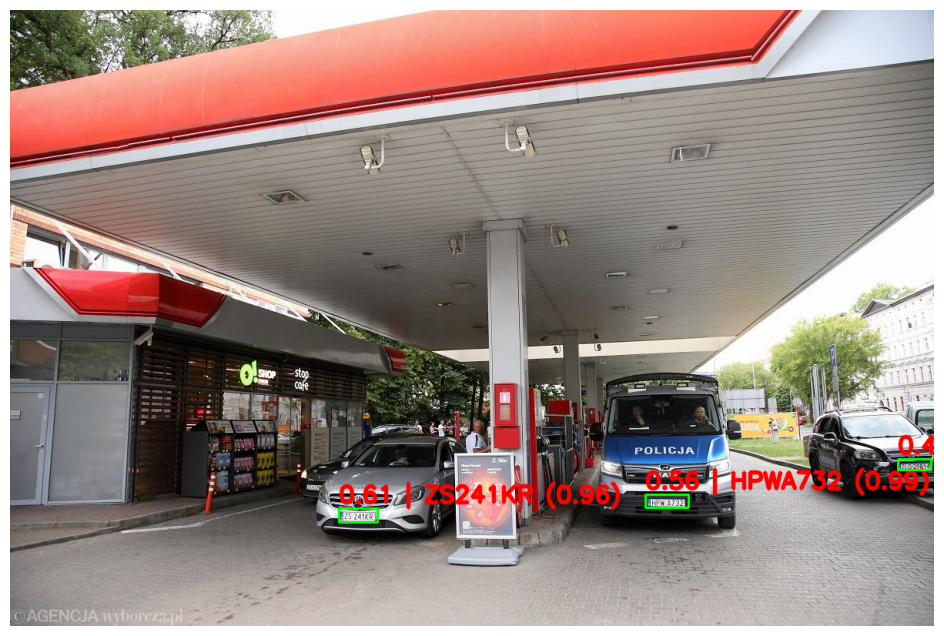

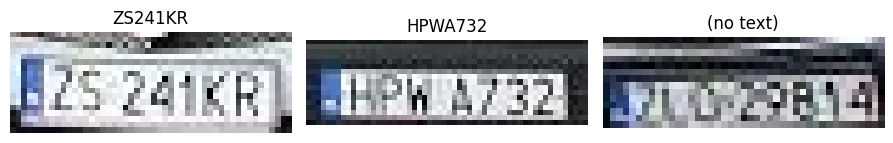

In [21]:
# Optional: visualize detections + crops

img_vis = original_image.copy()

for d in detections:
    x1, y1, x2, y2 = d["bbox_xyxy"]
    label = f"{d['conf']:.2f}"
    if d["text"]:
        label += f" | {d['text']} ({(d['text_score'] or 0):.2f})"

    cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(
        img_vis,
        label,
        (x1, max(0, y1 - 8)),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 255),
        3,
        cv2.LINE_AA,
    )

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

if detections:
    n = len(detections)
    plt.figure(figsize=(4 * min(n, 4), 4 * ((n + 3) // 4)))
    for i, d in enumerate(detections, start=1):
        plt.subplot(((n + 3) // 4), 4, i)
        plt.imshow(cv2.cvtColor(d["crop_bgr"], cv2.COLOR_BGR2RGB))
        title = d["text"] if d["text"] else "(no text)"
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()